In [10]:
%matplotlib inline
import matplotlib.pylab as plt

import tensorflow as tf
import numpy as np

#Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

# write to TIF
from scipy.external import tifffile 

In [11]:
def DisplayArray(a, fmt='png', rng=[0,1]):
  """Display an array as a picture."""
  a = (a - rng[0])/float(rng[1] - rng[0])*255
  a = np.uint8(np.clip(a, 0, 255))
  f = BytesIO()
  PIL.Image.fromarray(a).save(f, fmt)
  clear_output(wait = True)
  display(Image(data=f.getvalue()))

In [12]:
sess = tf.InteractiveSession()


In [ ]:
def make_kernel(a):
  """Transform a 3D array into a convolution kernel"""
  a = np.asarray(a)
  a = a.reshape(list(a.shape) + [1,1])
  return tf.constant(a, dtype=1)

def simple_conv(x, k):
  """A simplified 2D convolution operation"""
  x = tf.expand_dims(tf.expand_dims(x, 0), -1)
  y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
  return y[0, :, :, 0]

def laplace(x):
  """Compute the 2D laplacian of an array"""
  laplace_k = make_kernel([[0.5, 1.0, 0.5],
                           [1.0, -6., 1.0],
                           [0.5, 1.0, 0.5]])
  return simple_conv_periodic(x, laplace_k)


In [20]:

def make_kernel_3d(a):
  """Transform a 3D array into a convolution kernel"""
  a = np.asarray(a)
  a = a.reshape(list(a.shape) + [1,1])
  return tf.constant(a, dtype=1)

def simple_conv_periodic_3d(x, k):
    """A simplified 2D convolution operation, with periodic boundaries"""
    x_shape = tf.shape(x)
    a = tf.tile(x, [3, 3, 3]) # copy image into a 3x3x3
    x = a[x_shape[0]-2:x_shape[0]*2+2, 
          x_shape[1]-2:x_shape[1]*2+2, 
          x_shape[1]-2:x_shape[1]*2+2] # cut out relevant part in the middle
    
    x = tf.expand_dims(tf.expand_dims(x, 0), -1) # add dimensions for batch_size and channels 
    y = tf.nn.conv3d(x, k, [1, 1, 1, 1, 1], padding='VALID')
    print(tf.shape(y))
    return y[0, 1:-1, 1:-1, 1:-1, 0]


def laplace_3d(x):
  """Compute the 3D laplacian of an array"""
  laplace_k = make_kernel_3d([[[0.0, 0.0, 0.0],
                           [0.0, 1.0, 0.0],
                           [0.0, 0.0, 0.0]]
                          ,
                          [[0.0, 1.0, 0.0],
                           [1.0, -6., 1.0],
                           [0.0, 1.0, 0.0]]
                          ,
                          [[0.0, 0.0, 0.0],
                           [0.0, 1.0, 0.0],
                           [0.0, 0.0, 0.0]]])
  return simple_conv_periodic_3d(x, laplace_k)

In [21]:
N = 50

# Set everything to zero
a_init = np.zeros([N, N, N], dtype=np.float32)
i_init = np.ones([N, N, N], dtype=np.float32)

# Random initial conditions
a_init = np.random.normal(loc=0.5, scale=0.1, size=[N,N,N])
a_init = np.array(a_init, dtype=np.float32)
i_init *= 0.1


In [22]:
# Create variables for simulation state
A = tf.Variable(a_init)
I = tf.Variable(i_init)

# Parameters
dt    = tf.placeholder(tf.float32, shape=())
rho   = tf.placeholder(tf.float32, shape=())
kappa = tf.placeholder(tf.float32, shape=())
rho_a = tf.placeholder(tf.float32, shape=())
mu_i  = tf.placeholder(tf.float32, shape=())
mu_a  = tf.placeholder(tf.float32, shape=())
alpha_a = tf.placeholder(tf.float32, shape=())
alpha_i = tf.placeholder(tf.float32, shape=())


In [23]:
# Discretized PDE update rules
A_ = A + dt * (alpha_a*laplace_3d(A) + (rho/I)*((A*A)/(1 + kappa*A*A)) - mu_a * A + rho_a)
I_ = I + dt * (alpha_i*laplace_3d(I) + rho*((A*A)/(1+kappa*A*A)) - mu_i * I)


Tensor("Shape_3:0", shape=(5,), dtype=int32)
Tensor("Shape_5:0", shape=(5,), dtype=int32)


In [24]:
# Operation to update the state
step = tf.group(
  A.assign(A_),
  I.assign(I_))

In [25]:
stoptime = 25000
ddt = 0.1
dx = 1.0
Da = 0.05
Di = 5.0
alphaa = np.float32((Da * ddt) / (dx*dx))
alphai = np.float32((Di * ddt) / (dx*dx))
print(alphaa, alphai)
    

0.005 0.5


KeyboardInterrupt: 

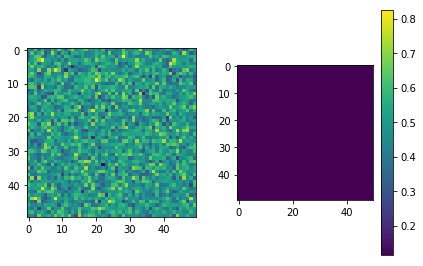

In [30]:
from ipywidgets import FloatProgress
from IPython.display import display
f = FloatProgress(min=0, max=stoptime)
display(f)

fig, ax = plt.subplots(ncols=2)
fig.tight_layout()
cax0 = ax[0].imshow(a_init[int(N/2)])
cax1 = ax[1].imshow(i_init[int(N/2)])
fig.colorbar(cax0)

# Initialize state to initial conditions
tf.global_variables_initializer().run()

# Run 1000 steps of PDE
count_fig = 0
for i in range(stoptime):
    f.value = i
    # Step simulation
    step.run({
            dt: ddt,
            rho: 0.001,
            rho_a: 0.001,
            kappa: 0.10,
            mu_i: 0.03,
            mu_a: 0.02,
            alpha_a: alphaa,
            alpha_i: alphai})
    if i % 1000 == 0:
        arr = A.eval()
        zslice = arr[int(N/2)] 
        DisplayArray(zslice, rng=[0.0, 1.0])
        cax0.set_data(zslice)
        cax1.set_data(zslice)
        fig.savefig('{}.png'.format(count_fig), dpi=300)
        count_fig+=1
        tifffile.imsave('AI_{:.03f}.tif'.format(counf_fig), arr, compress=6)

        
        

In [38]:
im = np.load('AI_17.000.pkl')

In [39]:
from skimage.external import tifffile
tifffile.imsave('AI.tif', im)